### Importing Libraries

First, I import the essential Python libraries required for this project:

- **NumPy** for numerical operations.  
- **Pandas** for handling and analyzing the dataset.  
- **Warnings** is used to suppress unnecessary warning messages, keeping the notebook output clean and readable.

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

### Importing Visualization Libraries

Here, I import the libraries needed for visualizing the data:

- **Matplotlib.pyplot** is used for creating 2D visualizations like scatter plots and bar charts.  
- **Axes3D** from `mpl_toolkits.mplot3d` allows me to create **3D plots**, which will help in visualizing clusters across three features later in the project.

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

### Importing Machine Learning Tools

I now import the machine learning utilities required for clustering:

- **StandardScaler**: Used to standardize the data so that all features contribute equally to clustering.  
- **KMeans**: The core algorithm for performing customer segmentation.  
- **Silhouette Score**: A metric to evaluate how well-defined the clusters are.  
- **PCA (Principal Component Analysis)**: Helps reduce dimensions for easier visualization of high-dimensional data.

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

### Setting Random State for Reproducibility  

To ensure consistent results every time I run the notebook, I set a fixed random state:  

- **RANDOM_STATE = 42**: A commonly used fixed seed value.  
- **np.random.seed(RANDOM_STATE)**: Ensures reproducibility for NumPy’s random number generation (important for clustering and PCA).  

In [4]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

### Display & Visualization Settings  

- **pd.set_option("display.max_columns", None)**: Ensures all columns of a DataFrame are displayed without being truncated.  
- **plt.style.use("ggplot")**: Applies the "ggplot" style to Matplotlib plots for cleaner and more visually appealing charts. 

In [5]:
pd.set_option("display.max_columns", None)
plt.style.use("ggplot")

### Loading the Dataset

In this step, I load the customer data from the CSV file into a Pandas DataFrame:

- **pd.read_csv("Mall_Customers.csv")** reads the dataset file named "Mall_Customers.csv".  
- The resulting DataFrame **df_raw** contains all the raw customer information that I will analyze and cluster in this project.

In [6]:
df_raw = pd.read_csv("Mall_Customers.csv")

### Cleaning and Standardizing Column Names

Here, I define a function and apply it to clean the DataFrame’s column names:

- The **clean_col** function formats each column name by:
  - Removing leading/trailing spaces with `strip()`.
  - Replacing spaces and hyphens with underscores for consistency.
  - Removing parentheses.
  - Converting all characters to lowercase for uniformity.
- I create a copy of the raw DataFrame called **df** to preserve the original data.
- Then, I update the columns of **df** using the cleaned names for easier and error-free reference in later code.

In [7]:
def clean_col(c):
    return (c.strip()
              .replace(" ", "_")
              .replace("(", "")
              .replace(")", "")
              .replace("-", "_")
              .lower())

df = df_raw.copy()
df.columns = [clean_col(c) for c in df.columns]

### Standardizing Column Names Further

To maintain consistent and clear column names, I perform the following renaming steps:

- If the column **"genre"** exists but **"gender"** does not, rename **"genre"** to **"gender"** for uniformity.  
- Define a dictionary **rename_map** to map longer or less clear column names to simpler, standardized names:
  - Rename `"annual_income_k$"` to `"annual_income_k"`.
  - Rename `"spending_score_1_100"` to `"spending_score"`.
- I apply these renamings only if the specified columns exist in the DataFrame, ensuring the code adapts flexibly to different versions of the dataset.

In [8]:
if "genre" in df.columns and "gender" not in df.columns:
    df.rename(columns={"genre": "gender"}, inplace=True)

rename_map = {
    "annual_income_k$": "annual_income_k",
    "spending_score_1_100": "spending_score"
}
df.rename(columns={k:v for k,v in rename_map.items() if k in df.columns}, inplace=True)

### Checking Dataset Overview

I print basic information to understand the structure and contents of the DataFrame:

- Display the list of **column names** to confirm the current state after renaming.  
- Show the **shape** (number of rows and columns) to know the dataset size.  
- Print the **first 3 rows** using `head(3)` to get an initial look at the data values and verify successful loading and cleaning.

In [9]:
print("Columns:", list(df.columns))
print("\nShape:", df.shape)
print("\nHead:\n", df.head(3))

Columns: ['customerid', 'gender', 'age', 'annual_income_k', 'spending_score']

Shape: (200, 5)

Head:
    customerid  gender  age  annual_income_k  spending_score
0           1    Male   19               15              39
1           2    Male   21               15              81
2           3  Female   20               16               6


### Getting Detailed DataFrame Information

Here, I use `df.info()` to get a summary of the DataFrame's structure:

- Displays the **number of entries**, **column names**, and their corresponding **data types**.  
- Shows the **non-null count** for each column to identify any missing data.  
- Helps confirm whether the dataset is clean and ready for analysis or requires further preprocessing.

In [10]:
print("\nInfo:")
print(df.info())


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   customerid       200 non-null    int64 
 1   gender           200 non-null    object
 2   age              200 non-null    int64 
 3   annual_income_k  200 non-null    int64 
 4   spending_score   200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None


### Checking for Missing Values and Duplicates

To ensure data quality, I check for potential issues:

- Use `df.isna().sum()` to count the number of **missing values** in each column, helping identify if any columns require imputation or removal.  
- Use `df.duplicated().sum()` to count **duplicate rows**, which can distort analysis and clustering if not addressed.

In [11]:
print("\nMissing values per column:\n", df.isna().sum())
print("\nDuplicate rows:", df.duplicated().sum())


Missing values per column:
 customerid         0
gender             0
age                0
annual_income_k    0
spending_score     0
dtype: int64

Duplicate rows: 0


### Statistical Summary of the Dataset

I use `df.describe(include="all")` to generate a comprehensive summary of the dataset:

- Provides key **statistics for numeric columns** such as count, mean, standard deviation, min, max, and quartiles.  
- For **categorical columns**, it shows count, unique values, most frequent value, and its frequency.  
- This overview helps understand the distribution and characteristics of each feature before proceeding with clustering.

In [12]:
display(df.describe(include="all"))

,customerid,gender,age,annual_income_k,spending_score
count,200.000000,200,200.000000,200.000000,200.000000
unique,NaN,2,NaN,NaN,NaN
top,NaN,Female,NaN,NaN,NaN
freq,NaN,112,NaN,NaN,NaN
mean,100.500000,NaN,38.850000,60.560000,50.200000
std,57.879185,NaN,13.969007,26.264721,25.823522
min,1.000000,NaN,18.000000,15.000000,1.000000
25%,50.750000,NaN,28.750000,41.500000,34.750000
50%,100.500000,NaN,36.000000,61.500000,50.000000
75%,150.250000,NaN,49.000000,78.000000,73.000000


### Cleaning Gender Column Values

To standardize the values in the **gender** column:

- Check if the **gender** column exists and its data type is object (string).  
- Remove any leading or trailing spaces using `str.strip()`.  
- Convert the text to title case with `str.title()` so all entries have a consistent format (e.g., "Male" instead of "male" or "MALE").

In [13]:
if "gender" in df.columns and df["gender"].dtype == object:
    df["gender"] = df["gender"].str.strip().str.title()

### Selecting Numerical Columns for Clustering

I define the list of key numerical columns to be used for analysis and clustering:

- The initial list includes `"age"`, `"annual_income_k"`, and `"spending_score"`.  
- I filter this list to include only those columns that actually exist in the DataFrame, ensuring robustness against dataset variations.

In [14]:
num_cols = ["age", "annual_income_k", "spending_score"]
num_cols = [c for c in num_cols if c in df.columns]

### Visualizing Distributions of Numerical Features

I create histograms to visualize the distribution of each selected numerical column:

- Use subplots to plot each numerical feature side-by-side for easy comparison.  
- For each column (`age`, `annual_income_k`, `spending_score`), plot the frequency distribution with 20 bins.  
- Titles and axis labels are set for clarity.  
- This helps identify data patterns, skewness, or outliers before clustering.

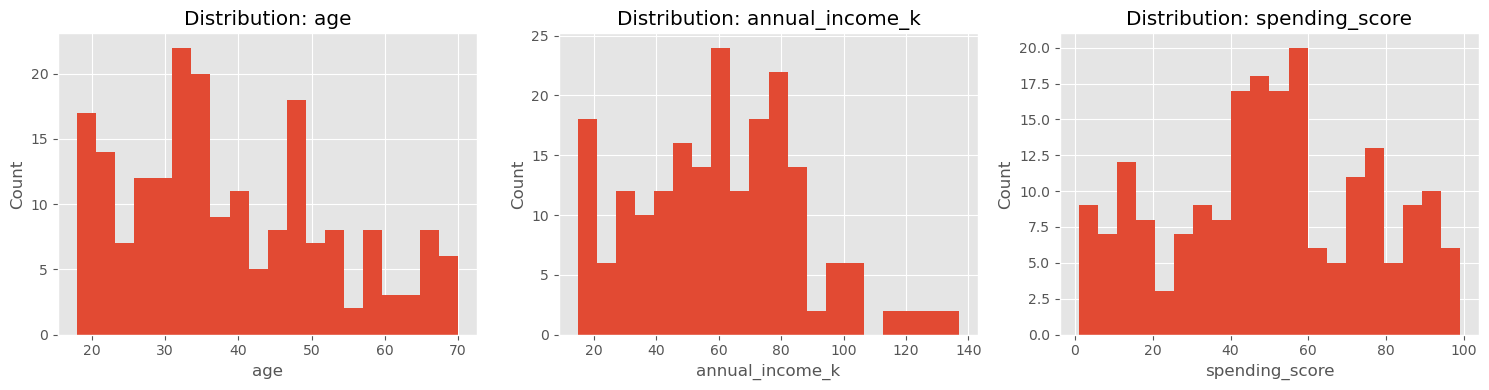

In [15]:
fig, axes = plt.subplots(1, len(num_cols), figsize=(5 * len(num_cols), 4))
if len(num_cols) == 1:
    axes = [axes]

for ax, col in zip(axes, num_cols):
    ax.hist(df[col].dropna(), bins=20)
    ax.set_title(f"Distribution: {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Count")

plt.tight_layout()
plt.show()

### Exploring Gender Distribution

To understand the composition of the dataset's gender variable:

- Calculate the **counts of each gender category** using `value_counts()`.  
- Print these counts to get numerical insight into the dataset's gender balance.  
- Visualize the distribution with a simple bar chart showing the number of customers per gender category.  
- This information is useful for demographic insights and to check for class imbalances.


Gender Counts:
 gender
Female    112
Male       88
Name: count, dtype: int64


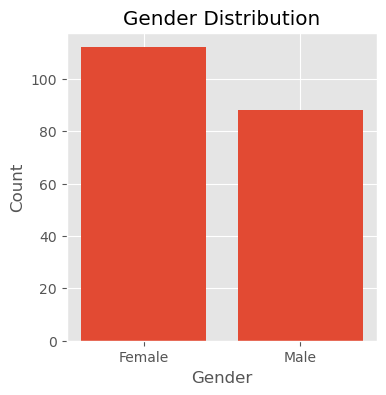

In [16]:
if "gender" in df.columns:
    gender_counts = df["gender"].value_counts()
    print("\nGender Counts:\n", gender_counts)
    plt.figure(figsize=(4,4))
    plt.bar(gender_counts.index.astype(str), gender_counts.values)
    plt.title("Gender Distribution")
    plt.xlabel("Gender"); plt.ylabel("Count")
    plt.show()

### Selecting Features for 2D Clustering

I prepare the dataset for k-means clustering using two key numerical features:

- Choose **"annual_income_k"** and **"spending_score"** as the two dimensions for clustering analysis.  
- Verify that both columns exist in the DataFrame to avoid errors.  
- Extract the values of these columns into a NumPy array **X2**, which will be used as input for the clustering algorithm.

In [17]:
features_2d = ["annual_income_k", "spending_score"]
for c in features_2d:
    if c not in df.columns:
        raise ValueError(f"Required column '{c}' not found in the dataset.")

X2 = df[features_2d].values

### Scaling 2D Features for Clustering

To ensure that features contribute equally to the clustering process, I scale the 

- Use **StandardScaler** to standardize features by removing the mean and scaling to unit variance.  
- Apply scaling to the 2D feature matrix **X2**, resulting in **X2_scaled**.  
- Print the shape of the scaled feature matrix to confirm successful transformation and readiness for clustering.

In [18]:
scaler2 = StandardScaler()
X2_scaled = scaler2.fit_transform(X2)

print("2D feature matrix prepared and scaled. Shape:", X2_scaled.shape)

2D feature matrix prepared and scaled. Shape: (200, 2)


### Evaluating Optimal Number of Clusters with K-Means

I run k-means clustering for a range of cluster counts to identify the best number of clusters:

- Define cluster counts **Ks** from 2 to 10.  
- For each **k**, initialize the k-means model with fixed random state and `n_init=10` for stability.  
- Fit the model on the scaled 2D feature data and predict cluster labels.  
- Store the **inertia** (sum of squared distances to cluster centers) and **silhouette score** (measure of cluster cohesion and separation) for each k.  
- These metrics will help determine the optimal cluster number visually.

In [19]:
inertias, silhouettes, Ks = [], [], list(range(2, 11))

for k in Ks:
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    labels = km.fit_predict(X2_scaled)
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X2_scaled, labels))

### Visualizing the Elbow Method for 2D Clustering

I plot the inertia values for different numbers of clusters to find the optimal k:

- The **Elbow Method** helps identify the point where adding more clusters no longer significantly reduces inertia.  
- Plot inertia against cluster count **k**, with markers to highlight each point.  
- The "elbow" in the plot suggests the best trade-off between cluster compactness and complexity.

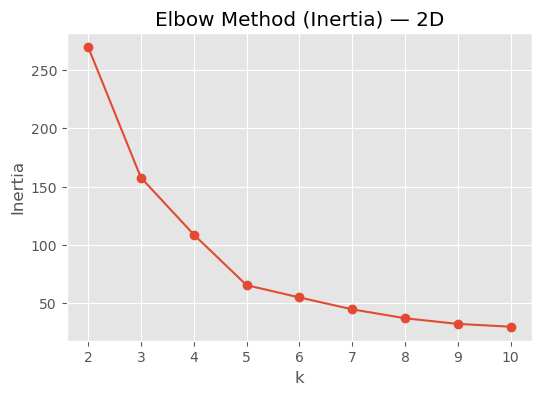

In [20]:
plt.figure(figsize=(6,4))
plt.plot(Ks, inertias, marker="o")
plt.xticks(Ks)
plt.title("Elbow Method (Inertia) — 2D")
plt.xlabel("k"); plt.ylabel("Inertia")
plt.show()

### Visualizing Silhouette Scores for 2D Clustering

I use the silhouette scores to evaluate the quality of clustering across different cluster counts:

- The **Silhouette Score** measures how well-separated and cohesive the clusters are, with higher values indicating better-defined clusters.  
- Plot the silhouette scores against cluster count **k** to identify the number of clusters that maximize cluster separation.  
- This plot complements the Elbow Method and helps confirm the optimal number of clusters.

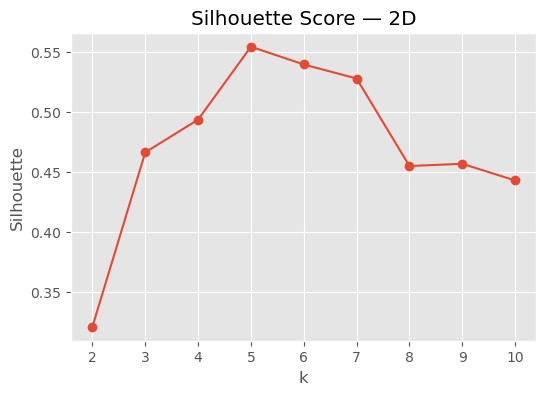

In [21]:
plt.figure(figsize=(6,4))
plt.plot(Ks, silhouettes, marker="o")
plt.xticks(Ks)
plt.title("Silhouette Score — 2D")
plt.xlabel("k"); plt.ylabel("Silhouette")
plt.show()

### Selecting the Best Number of Clusters Based on Silhouette Score

From the silhouette scores, I select the optimal number of clusters:

- Use `np.argmax` to find the index of the highest silhouette score in the list.  
- Map that index to the corresponding cluster count in **Ks**.  
- Print the chosen cluster count and the maximum silhouette score for transparency and reference in the clustering step.

In [22]:
best_k2 = Ks[int(np.argmax(silhouettes))]
print(f"Chosen k (2D) by silhouette: {best_k2}  | Max silhouette: {max(silhouettes):.3f}")

Chosen k (2D) by silhouette: 5  | Max silhouette: 0.555


### Fitting K-Means with Optimal Clusters and Labeling Data

Using the chosen number of clusters from the silhouette analysis:

- Initialize k-means with **best_k2** clusters and fixed random state for reproducibility.  
- Fit the model on the scaled 2D data and obtain cluster assignments as **labels2**.  
- Add the cluster labels back to the original DataFrame in a new column **"cluster_2d"**, associating each customer with its cluster.  
- Convert the cluster centers from the scaled feature space back to the original data scale using inverse transform for meaningful visualization later.

In [23]:
kmeans2 = KMeans(n_clusters=best_k2, random_state=RANDOM_STATE, n_init=10)
labels2 = kmeans2.fit_predict(X2_scaled)

# Add labels back to df
df["cluster_2d"] = labels2

# Inverse-transform centers to original scale for plotting in original axes
centers2_original = scaler2.inverse_transform(kmeans2.cluster_centers_)

### Visualizing 2D K-Means Clusters

I plot the customer clusters based on annual income and spending score:

- For each cluster, plot the customers' data points in a scatter plot with different colors and labels.  
- Overlay the cluster centers as larger "X" markers with a distinct style for clear identification.  
- The plot provides an intuitive visual representation of how customers group based on their income and spending habits, aiding interpretation of the clustering results.

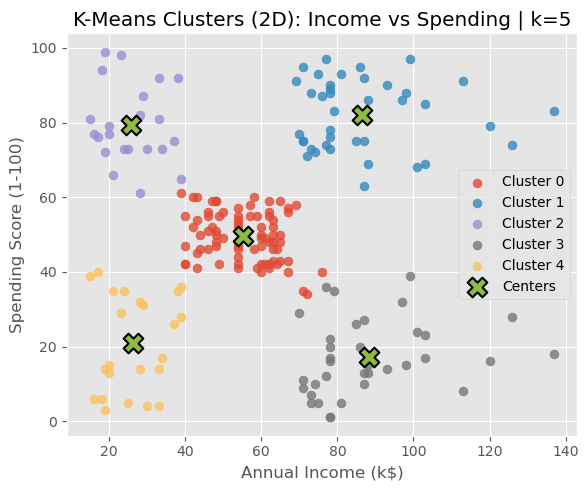

In [24]:
plt.figure(figsize=(6,5))
for cluster_id in range(best_k2):
    mask = df["cluster_2d"] == cluster_id
    plt.scatter(df.loc[mask, "annual_income_k"], df.loc[mask, "spending_score"], s=40, alpha=0.8, label=f"Cluster {cluster_id}")

plt.scatter(centers2_original[:,0], centers2_original[:,1], s=200, marker="X", edgecolor="black", linewidth=1.5, label="Centers")
plt.title(f"K-Means Clusters (2D): Income vs Spending | k={best_k2}")
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")
plt.legend()
plt.tight_layout()
plt.show()

### Displaying Cluster Centers in Original Scale

I present the exact coordinates of cluster centers in the original feature units:

- Convert the inverse-transformed cluster centers into a DataFrame for clear tabular display.  
- This allows easy interpretation of typical customer profiles within each cluster based on **annual income** and **spending score**.

In [25]:
print("Cluster centers (original scale):")
centers_2d_df = pd.DataFrame(centers2_original, columns=features_2d)
display(centers_2d_df)

Cluster centers (original scale):


,annual_income_k,spending_score
0,55.296296,49.518519
1,86.538462,82.128205
2,25.727273,79.363636
3,88.200000,17.114286
4,26.304348,20.913043


### Profiling 2D Clusters with Customer Statistics

To better understand each cluster, I summarize key customer attributes:

- Group the DataFrame by the **"cluster_2d"** labels.  
- Calculate **mean, median, minimum, and maximum** values for the important profile columns: age, annual income, and spending score.  
- Round these statistics to two decimal places for readability.  
- Display the aggregated profile statistics to characterize the typical customer in each cluster.  
- Also print the count of customers per cluster to see the cluster sizes.

In [26]:
profile_cols = ["age", "annual_income_k", "spending_score"]
profile_cols = [c for c in profile_cols if c in df.columns]

profile_2d = df.groupby("cluster_2d")[profile_cols].agg(["mean", "median", "min", "max"]).round(2)
counts_2d = df["cluster_2d"].value_counts().sort_index()
display(profile_2d)
print("\nCounts per cluster:\n", counts_2d)

age                annual_income_k                  \
             mean median min max            mean median min  max   
cluster_2d                                                         
0           42.72   46.0  18  70           55.30   54.0  39   76   
1           32.69   32.0  27  40           86.54   79.0  69  137   
2           25.27   23.5  18  35           25.73   24.5  15   39   
3           41.11   42.0  19  59           88.20   85.0  70  137   
4           45.22   46.0  19  67           26.30   25.0  15   39   

           spending_score                 
                     mean median min max  
cluster_2d                                
0                   49.52   50.0  34  61  
1                   82.13   83.0  63  97  
2                   79.36   77.0  61  99  
3                   17.11   16.0   1  39  
4                   20.91   17.0   3  40


Counts per cluster:
 cluster_2d
0    81
1    39
2    22
3    35
4    23
Name: count, dtype: int64


### Analyzing Gender Composition within Clusters

To explore the demographic distribution in each cluster:

- Use a cross-tabulation between **cluster_2d** and **gender** to compute the proportion of each gender in every cluster.  
- Normalize by row to show the relative gender mix within each cluster as percentages.  
- Display the results to understand gender patterns or imbalances across customer segments.

In [27]:
if "gender" in df.columns:
    gender_mix_2d = pd.crosstab(df["cluster_2d"], df["gender"], normalize="index").round(3)
    print("\nGender mix within clusters (row-normalized):")
    display(gender_mix_2d)


Gender mix within clusters (row-normalized):


gender,Female,Male
cluster_2d,,
0,0.593,0.407
1,0.538,0.462
2,0.591,0.409
3,0.457,0.543
4,0.609,0.391


### Ranking Clusters by Average Income and Spending

To compare clusters more intuitively, I rank them based on their mean values:

- Group by 2D cluster labels and calculate the mean **annual income** and **spending score** for each cluster.  
- Use dense ranking to assign ranks where 1 equals the lowest average and higher ranks indicate higher averages.  
- Display the ranked clusters to easily identify groups with lower or higher income and spending profiles.

In [28]:
means_2d = df.groupby("cluster_2d")[["annual_income_k", "spending_score"]].mean()
means_2d_ranked = means_2d.rank(method="dense")
print("\nRelative ranking of clusters by mean income & spending (1=lowest, higher=more):")
display(means_2d_ranked.astype(int))


Relative ranking of clusters by mean income & spending (1=lowest, higher=more):


,annual_income_k,spending_score
cluster_2d,,
0,3,3
1,4,5
2,1,4
3,5,1
4,2,2


### Preparing 3D Feature Set for Clustering

I extend clustering analysis to three dimensions by including age along with income and spending:

- Define the three features: **age**, **annual_income_k**, and **spending_score**.  
- Ensure all required columns exist in the DataFrame to prevent errors.  
- Extract these features into a NumPy array **X3** for processing.  
- Scale the features using **StandardScaler** to normalize their ranges, resulting in **X3_scaled**.  
- Initialize empty lists to store evaluation metrics (**inertias3, silhouettes3**) and define cluster counts **Ks3** for k ranging from 2 to 10.

In [29]:
features_3d = ["age", "annual_income_k", "spending_score"]
for c in features_3d:
    if c not in df.columns:
        raise ValueError(f"Required column '{c}' not found in the dataset.")

X3 = df[features_3d].values

scaler3 = StandardScaler()
X3_scaled = scaler3.fit_transform(X3)

inertias3, silhouettes3, Ks3 = [], [], list(range(2, 11))

### Evaluating Optimal Clusters for 3D Features with Elbow Method

I run k-means clustering on the scaled 3D feature set for a range of cluster counts:

- For each **k** in the range 2 to 10, fit a k-means model and predict cluster labels.  
- Store the model inertia (sum of squared distances) and silhouette scores to evaluate cluster quality.  
- Plot the inertia values against cluster count to visualize the Elbow Method, helping identify the ideal number of clusters based on diminishing returns.

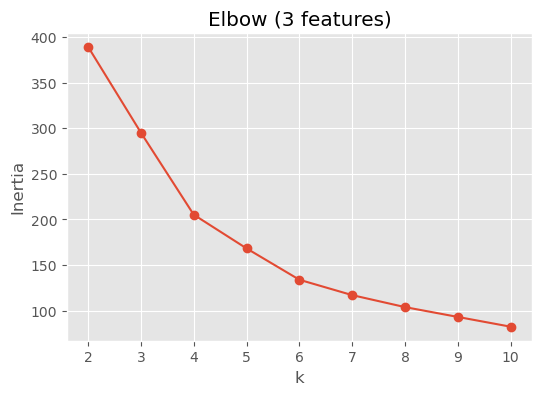

In [30]:
for k in Ks3:
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    lbl = km.fit_predict(X3_scaled)
    inertias3.append(km.inertia_)
    silhouettes3.append(silhouette_score(X3_scaled, lbl))

plt.figure(figsize=(6,4))
plt.plot(Ks3, inertias3, marker="o")
plt.xticks(Ks3); plt.title("Elbow (3 features)")
plt.xlabel("k"); plt.ylabel("Inertia")
plt.show()

### Visualizing Silhouette Scores for 3D Clustering

I plot the silhouette scores for different cluster counts to assess cluster quality:

- The silhouette score reflects the degree of cluster separation and cohesion, with higher values indicating better-defined clusters.  
- Plot silhouette scores against **k** to identify the number of clusters that maximize silhouette, complementing the Elbow Method results.  
- This visualization guides the choice of the best **k** for 3D clustering.

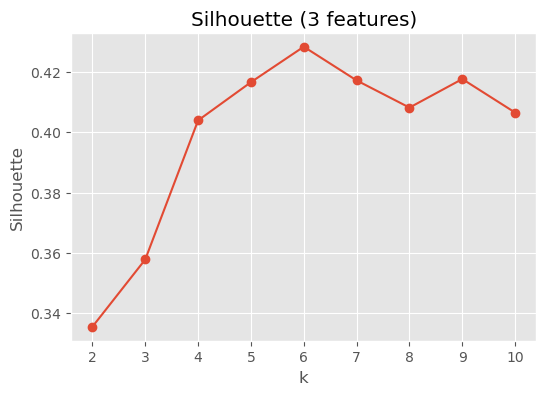

In [31]:
plt.figure(figsize=(6,4))
plt.plot(Ks3, silhouettes3, marker="o")
plt.xticks(Ks3); plt.title("Silhouette (3 features)")
plt.xlabel("k"); plt.ylabel("Silhouette")
plt.show()

### Selecting Optimal Number of Clusters for 3D Data 

Based on the silhouette scores, I determine the best number of clusters:

- Identify the index of the highest silhouette score using `np.argmax`.  
- Map this index to the corresponding cluster count in **Ks3**.  
- Print the chosen number of clusters and the maximum silhouette score, providing a quantitative basis for selecting **best_k3**.

In [32]:
best_k3 = Ks3[int(np.argmax(silhouettes3))]
print(f"Chosen k (3D) by silhouette: {best_k3} | Max silhouette: {max(silhouettes3):.3f}")

Chosen k (3D) by silhouette: 6 | Max silhouette: 0.428


### Fitting K-Means with Optimal Clusters on 3D Data

Using the selected best cluster count for three features:

- Initialize and fit k-means with **best_k3** clusters on scaled 3D features.  
- Predict cluster labels and assign these labels to the DataFrame column **"cluster_3d"**.  
- Inverse-transform the cluster centers back to their original scale for interpretability and visualization.

In [33]:
kmeans3 = KMeans(n_clusters=best_k3, random_state=RANDOM_STATE, n_init=10)
labels3 = kmeans3.fit_predict(X3_scaled)

df["cluster_3d"] = labels3
centers3_original = scaler3.inverse_transform(kmeans3.cluster_centers_)

### Visualizing 3D K-Means Clusters

I create a 3D scatter plot to visualize clusters based on age, annual income, and spending score:

- Plot each cluster's customers with distinct colors and markers in a 3D space.  
- Mark cluster centers with large "X" symbols for clear reference.  
- Label axes clearly and add a title indicating the number of clusters.  
- This visualization aids understanding of the customer segmentation in multiple dimensions.

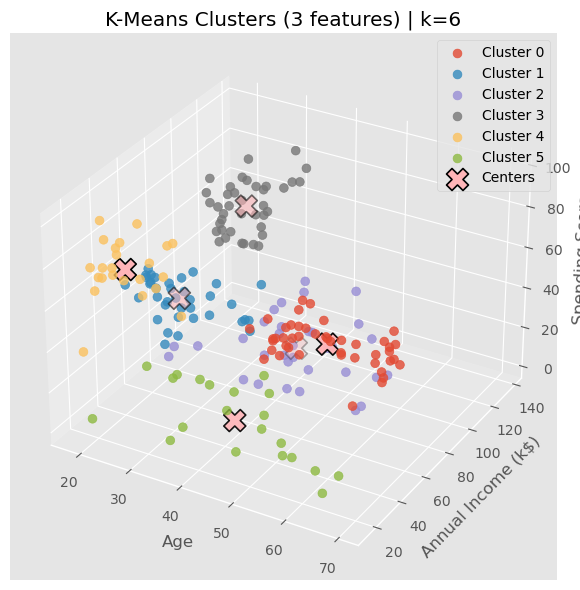

In [34]:
fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111, projection="3d")

for cluster_id in range(best_k3):
    mask = df["cluster_3d"] == cluster_id
    ax.scatter(df.loc[mask, "age"],
               df.loc[mask, "annual_income_k"],
               df.loc[mask, "spending_score"],
               s=40, alpha=0.8, label=f"Cluster {cluster_id}")

ax.scatter(centers3_original[:,0], centers3_original[:,1], centers3_original[:,2],
           s=250, marker="X", edgecolor="black", linewidth=1.2, label="Centers")

ax.set_title(f"K-Means Clusters (3 features) | k={best_k3}")
ax.set_xlabel("Age"); ax.set_ylabel("Annual Income (k$)"); ax.set_zlabel("Spending Score")
ax.legend()
plt.tight_layout()
plt.show()

### Visualizing 3D Clusters in 2D with PCA

To better visualize clusters in a simpler 2D plane, I apply PCA:

- Perform Principal Component Analysis on the scaled 3D data to reduce it to 2 components that capture most variance.  
- Plot the clusters in this 2D PCA space, coloring points by their 3D cluster labels.  
- Display the total variance explained by the two principal components for context.  
- This aids visual interpretation of the cluster separation in reduced dimensions.

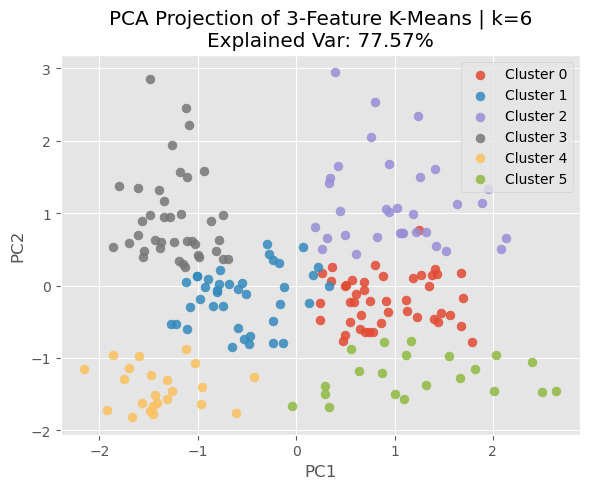

In [35]:
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X3_pca = pca.fit_transform(X3_scaled)

plt.figure(figsize=(6,5))
for cluster_id in range(best_k3):
    mask = df["cluster_3d"] == cluster_id
    plt.scatter(X3_pca[mask, 0], X3_pca[mask, 1], s=40, alpha=0.85, label=f"Cluster {cluster_id}")

plt.title(f"PCA Projection of 3-Feature K-Means | k={best_k3}\nExplained Var: {pca.explained_variance_ratio_.sum():.2%}")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend()
plt.tight_layout()
plt.show()

### Displaying 3D Cluster Centers in Original Scale

I provide a clear tabular view of the cluster centers after inverse scaling:

- Convert the 3D cluster centers to a DataFrame with columns labeled by the original feature names: age, annual income, and spending score.  
- Display these centers to understand the typical customer profiles represented by each cluster in the original units.

In [36]:
print("Cluster centers (original scale, 3 features):")
display(pd.DataFrame(centers3_original, columns=features_3d))

Cluster centers (original scale, 3 features):


,age,annual_income_k,spending_score
0,56.333333,54.266667,49.066667
1,26.794872,57.102564,48.128205
2,41.939394,88.939394,16.969697
3,32.692308,86.538462,82.128205
4,25.000000,25.260870,77.608696
5,45.523810,26.285714,19.380952


### Defining Functions to Name Clusters Based on Income and Spending

I define two helper functions to label customer clusters meaningfully:

- `level_from_value(v, q_low, q_high)`: Categorizes a numeric value `v` as "Low", "Mid", or "High" based on lower and upper quantile thresholds.  
- `propose_names_by_income_spend(cluster_means)`:  
  - Takes a DataFrame with average **annual_income_k** and **spending_score** per cluster.  
  - Computes 33rd and 67th quantiles for income and spending to define thresholds.  
  - Assigns each cluster to an income and spending level using `level_from_value`.  
  - Maps combined levels to descriptive cluster names (e.g., "Champions", "Value Seekers").  
  - Returns a dictionary mapping cluster IDs to proposed cluster names for better interpretability.

In [37]:
def level_from_value(v, q_low, q_high):
    if v <= q_low: return "Low"
    if v >= q_high: return "High"
    return "Mid"

def propose_names_by_income_spend(cluster_means):
    # cluster_means: DataFrame with ['annual_income_k','spending_score']
    q_income = cluster_means["annual_income_k"].quantile([0.33, 0.67]).values
    q_spend  = cluster_means["spending_score"].quantile([0.33, 0.67]).values
    
    names = {}
    for cid, row in cluster_means.iterrows():
        income_level = level_from_value(row["annual_income_k"], q_income[0], q_income[1])
        spend_level  = level_from_value(row["spending_score"],  q_spend[0],  q_spend[1])
        key = (income_level, spend_level)
        
        label_map = {
            ("High","High"): "Champions",
            ("High","Mid"):  "Affluent Pragmatists",
            ("High","Low"):  "Careful Big Earners",
            ("Mid","High"):  "Potential Loyalists",
            ("Mid","Mid"):   "Steady Regulars",
            ("Mid","Low"):   "Value Seekers",
            ("Low","High"):  "Aspirational Spenders",
            ("Low","Mid"):   "Price Sensitive",
            ("Low","Low"):   "Budget-Conscious",
        }
        names[cid] = label_map.get(key, f"{income_level}-{spend_level}")
    return names

### Assigning Meaningful Segment Names to Clusters

Using the income and spending means, I propose intuitive segment names for both 2D and 3D clustering results:

- Compute cluster-wise mean income and spending for the 2D clusters, then generate segment names using the defined naming function. Map these names back to the DataFrame in **"segment_2d"**.  
- Repeat the same process for 3D clusters to produce **"segment_3d"**, ensuring consistent interpretation across models based on income and spending levels.  
- Print the proposed segment name mappings for transparency.  
- Display a preview of relevant customer info, cluster assignments, and corresponding segment names for the first 10 customers to illustrate the labeling.

In [38]:
# Names for the 2D model
means2 = df.groupby("cluster_2d")[["annual_income_k","spending_score"]].mean()
names2 = propose_names_by_income_spend(means2)
print("Proposed segment names (2D model):", names2)
df["segment_2d"] = df["cluster_2d"].map(names2)

# Names for the 3D model (still using income+spending to keep interpretation aligned)
means3 = df.groupby("cluster_3d")[["annual_income_k","spending_score"]].mean()
names3 = propose_names_by_income_spend(means3)
print("Proposed segment names (3D model):", names3)
df["segment_3d"] = df["cluster_3d"].map(names3)

display(df[["customerid","age","annual_income_k","spending_score","cluster_2d","segment_2d","cluster_3d","segment_3d"]].head(10))

Proposed segment names (2D model): {0: 'Steady Regulars', 1: 'Champions', 2: 'Aspirational Spenders', 3: 'Careful Big Earners', 4: 'Budget-Conscious'}
Proposed segment names (3D model): {0: 'Steady Regulars', 1: 'Steady Regulars', 2: 'Careful Big Earners', 3: 'Champions', 4: 'Aspirational Spenders', 5: 'Budget-Conscious'}


,customerid,age,annual_income_k,spending_score,cluster_2d,segment_2d,cluster_3d,segment_3d
0,1,19,15,39,4,Budget-Conscious,4,Aspirational Spenders
1,2,21,15,81,2,Aspirational Spenders,4,Aspirational Spenders
2,3,20,16,6,4,Budget-Conscious,5,Budget-Conscious
3,4,23,16,77,2,Aspirational Spenders,4,Aspirational Spenders
4,5,31,17,40,4,Budget-Conscious,5,Budget-Conscious
5,6,22,17,76,2,Aspirational Spenders,4,Aspirational Spenders
6,7,35,18,6,4,Budget-Conscious,5,Budget-Conscious
7,8,23,18,94,2,Aspirational Spenders,4,Aspirational Spenders
8,9,64,19,3,4,Budget-Conscious,5,Budget-Conscious
9,10,30,19,72,2,Aspirational Spenders,4,Aspirational Spenders


### Generating Detailed Cluster Segment Reports

I define a function to summarize and report customer segment characteristics:

- For each segment (given by `label_col`), compute descriptive stats (mean, median, min, max) for age, annual income, and spending score.  
- Show counts of customers per segment for size context.  
- If gender data is available, include the normalized gender distribution within each segment to highlight demographic composition.  
- Use this function to produce clear, informative summary reports for both the 2D and 3D clustering-based segmentations.  
- This provides actionable insights into segment profiles for better interpretation and targeting.

In [39]:
def cluster_report(df, label_col, title):
    cols = ["age","annual_income_k","spending_score"]
    cols = [c for c in cols if c in df.columns]
    summary = df.groupby(label_col)[cols].agg(["mean","median","min","max"]).round(2)
    counts = df[label_col].value_counts().sort_index()
    print(f"\n=== {title} ===")
    print("Counts:\n", counts)
    display(summary)
    if "gender" in df.columns:
        gender_mix = pd.crosstab(df[label_col], df["gender"], normalize="index").round(3)
        print("\nGender mix (row-normalized):")
        display(gender_mix)

cluster_report(df, "segment_2d", "Segment Report — 2D Model")
cluster_report(df, "segment_3d", "Segment Report — 3D Model")


=== Segment Report — 2D Model ===
Counts:
 segment_2d
Aspirational Spenders    22
Budget-Conscious         23
Careful Big Earners      35
Champions                39
Steady Regulars          81
Name: count, dtype: int64


age                annual_income_k                  \
                        mean median min max            mean median min  max   
segment_2d                                                                    
Aspirational Spenders  25.27   23.5  18  35           25.73   24.5  15   39   
Budget-Conscious       45.22   46.0  19  67           26.30   25.0  15   39   
Careful Big Earners    41.11   42.0  19  59           88.20   85.0  70  137   
Champions              32.69   32.0  27  40           86.54   79.0  69  137   
Steady Regulars        42.72   46.0  18  70           55.30   54.0  39   76   

                      spending_score                 
                                mean median min max  
segment_2d                                           
Aspirational Spenders          79.36   77.0  61  99  
Budget-Conscious               20.91   17.0   3  40  
Careful Big Earners            17.11   16.0   1  39  
Champions                      82.13   83.0  63  97  
Steady Regulars                49.52   50.0  34  61


Gender mix (row-normalized):


gender,Female,Male
segment_2d,,
Aspirational Spenders,0.591,0.409
Budget-Conscious,0.609,0.391
Careful Big Earners,0.457,0.543
Champions,0.538,0.462
Steady Regulars,0.593,0.407



=== Segment Report — 3D Model ===
Counts:
 segment_3d
Aspirational Spenders    23
Budget-Conscious         21
Careful Big Earners      33
Champions                39
Steady Regulars          84
Name: count, dtype: int64


age                annual_income_k                  \
                        mean median min max            mean median min  max   
segment_3d                                                                    
Aspirational Spenders  25.00   23.0  18  35           25.26   24.0  15   39   
Budget-Conscious       45.52   46.0  20  67           26.29   25.0  16   39   
Careful Big Earners    41.94   43.0  19  59           88.94   86.0  71  137   
Champions              32.69   32.0  27  40           86.54   79.0  69  137   
Steady Regulars        42.62   46.5  18  70           55.58   55.5  38   79   

                      spending_score                 
                                mean median min max  
segment_3d                                           
Aspirational Spenders          77.61   77.0  39  99  
Budget-Conscious               19.38   15.0   3  40  
Careful Big Earners            16.97   16.0   1  39  
Champions                      82.13   83.0  63  97  
Steady Regulars                48.63   49.0  10  61


Gender mix (row-normalized):


gender,Female,Male
segment_3d,,
Aspirational Spenders,0.565,0.435
Budget-Conscious,0.619,0.381
Careful Big Earners,0.424,0.576
Champions,0.538,0.462
Steady Regulars,0.607,0.393


### Saving the Segmented Customer Dataset

I create an output directory named **"outputs_kmeans_customer_segmentation"** if it doesn't already exist:

- Make a copy of the DataFrame with assigned cluster and segment labels to avoid modifying original data inadvertently.  
- Save this enhanced dataset as a CSV file named **"mall_customers_with_segments.csv"** inside the output directory.  
- This saved file preserves the clustering results for future analysis, sharing, or deployment.

In [40]:
import os

OUT_DIR = "outputs_kmeans_customer_segmentation"
os.makedirs(OUT_DIR, exist_ok=True)

# Save labeled datasets
df_out = df.copy()
df_out.to_csv(os.path.join(OUT_DIR, "mall_customers_with_segments.csv"), index=False)

### Saving 2D Cluster Plot as an Image File

I recreate the 2D cluster scatter plot and save it as a high-resolution PNG file:

- Plot customers grouped by their 2D cluster labels with distinct colors.  
- Mark cluster centers with prominent "X" markers for clear identification.  
- Label axes and add a title with the selected number of clusters.  
- Save the figure as **"clusters_2d_income_spending.png"** in the output directory with 200 DPI for clarity.  
- Display the plot for immediate visual review.

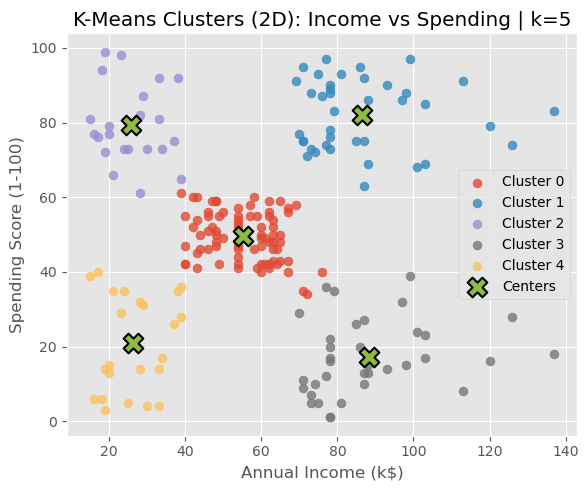

In [41]:
plt.figure(figsize=(6,5))
for cluster_id in sorted(df["cluster_2d"].unique()):
    mask = df["cluster_2d"] == cluster_id
    plt.scatter(df.loc[mask, "annual_income_k"], df.loc[mask, "spending_score"], s=40, alpha=0.8, label=f"Cluster {cluster_id}")
plt.scatter(centers2_original[:,0], centers2_original[:,1], s=200, marker="X", edgecolor="black", linewidth=1.5, label="Centers")
plt.title(f"K-Means Clusters (2D): Income vs Spending | k={best_k2}")
plt.xlabel("Annual Income (k$)"); plt.ylabel("Spending Score (1-100)")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "clusters_2d_income_spending.png"), dpi=200)
plt.show()

### Saving PCA Projection of 3D Clusters as Image

I plot and save the 2D PCA projection of the 3D k-means clusters:

- Plot clusters in the PCA-transformed space with distinct colors for each cluster.  
- Include the total explained variance by the two principal components in the title for context.  
- Label axes with PC1 and PC2 for clarity.  
- Save the figure as **"clusters_3d_pca2.png"** in the output directory with high resolution (200 DPI).  
- Display the plot for immediate visualization.

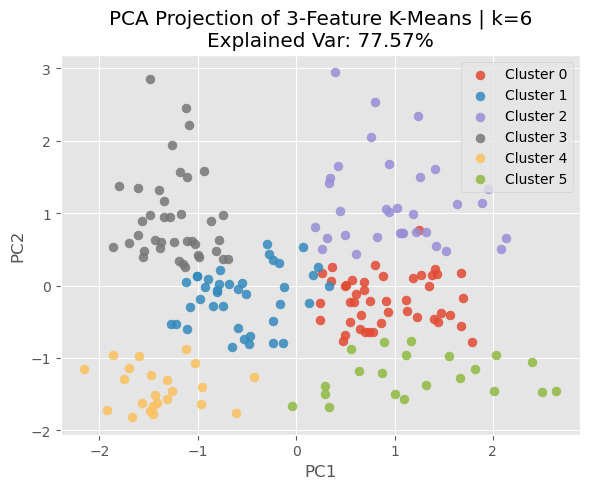

In [42]:
plt.figure(figsize=(6,5))
for cluster_id in sorted(df["cluster_3d"].unique()):
    mask = df["cluster_3d"] == cluster_id
    plt.scatter(X3_pca[mask, 0], X3_pca[mask, 1], s=40, alpha=0.85, label=f"Cluster {cluster_id}")
plt.title(f"PCA Projection of 3-Feature K-Means | k={best_k3}\nExplained Var: {pca.explained_variance_ratio_.sum():.2%}")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "clusters_3d_pca2.png"), dpi=200)
plt.show()

### Summary of Saved Files

The following files have been saved in the output directory for further use and analysis:

- Segmented customer dataset CSV:  
  outputs_kmeans_customer_segmentation/mall_customers_with_segments.csv  
- 2D cluster plot image (Income vs Spending):  
  outputs_kmeans_customer_segmentation/clusters_2d_income_spending.png  
- 3D cluster PCA projection image:  
  outputs_kmeans_customer_segmentation/clusters_3d_pca2.png

In [43]:
print(f"Saved:\n- {os.path.join(OUT_DIR, 'mall_customers_with_segments.csv')}\n- {os.path.join(OUT_DIR, 'clusters_2d_income_spending.png')}\n- {os.path.join(OUT_DIR, 'clusters_3d_pca2.png')}")

Saved:
- outputs_kmeans_customer_segmentation/mall_customers_with_segments.csv
- outputs_kmeans_customer_segmentation/clusters_2d_income_spending.png
- outputs_kmeans_customer_segmentation/clusters_3d_pca2.png
